# PuMaS.jl: Pharmaceutical Modeling and Simulation Engine

## JuliaCon 2018

## Chris Rackauckas

### Center for Translational Medicine, School of Pharmacy, University of Maryland Baltimore
### JuliaComputing
### Massachusetts Institute of Technology Department of Mathematics

### Center for Translational Medicine, School of Pharmacy, University of Maryland Baltimore

![Center for Translation Medicine](https://user-images.githubusercontent.com/1425562/43694589-10984578-9902-11e8-9bac-d441b517f730.png)

![image](https://user-images.githubusercontent.com/1425562/43874378-8bd412d6-9b59-11e8-9b8f-42723b4099de.png)

_source:https://www.cbinsights.com/research/clinical-trials-ai-tech-disruption/ _


## Comprehensive push towards modernization

Rate of new drug approvals has been on the decline since the 1990's

- Drug development costs $1.4billion over 12 years. 
- Old tried-and-true methods of process improvement not impactful

*FDA commisioner Scott Gottlieb in 2017*: 
>“FDA’s Center for Drug Evaluation and Research (CDER) is currently using modeling and simulation to predict clinical outcomes, inform clinical trial designs, support evidence of effectiveness, optimize dosing, predict product safety, and evaluate potential adverse event mechanisms. We’ll be putting out additional, updated guidance on how aspects of these in silico tools can be advanced and incorporated into different aspects of drug development."

## Bringing computational approaches to drug development and precision therapeutics is the future

- Computational modeling and simulation (M&S) can impact by:
    * Optimizing trial design (the number of patients, length, desired outcomes, protocols) to provide needed information on dosing and drug interactions, etc.
    * Eliminating the need for clinical trials in selected situations and populations (e.g., pediatrics or rare/orphan diseases, oncology, special populations)
    * Predicting what will happen under certain conditions, e.g., dosing, interactions with other drugs (DDI), in different patient populations
    * Enabling more informed commercial decisions around the benefits of a specific drug for specific population segments or indications.
    * Reduce development costs; minimize compound scientific, regulatory, and clinical uncertainty; increase likelihood of regulatory success; and reduce time-to-launch, thereby increasing the return on R&D investment (increase productivity).  
    * M&S can enable more targeted and precise dosing, reducing the need to run multi-arm dosing studies. As more data is made publicly available from clinical trials to use for M&S, the models and answers to “what-if” questions become better representations of reality.

## What happens to a medicine once it enters the body?

![Time course of drug after oral administration](https://user-images.githubusercontent.com/1425562/43694590-10a1ccba-9902-11e8-89d7-4f6c92845197.png)

Simplest mathematical representation of the profile can be defined by the ODE:

\begin{align}
 \frac{d[\text{Depot}]}{dt} &= -k_a [\text{Depot}] \\
 \frac{d[\text{Central}]}{dt} &=  k_a [\text{Depot}] - \frac{CL}{V} [\text{Central}]
\end{align}

**Values are purturbed via doses (events)**. Here we model that the ODE's coefficients are defined by covariates and random effects:

\begin{equation}
\begin{bmatrix}
         k_a \\
         CL \\
         V \\
      \end{bmatrix} = \begin{bmatrix}
         \theta_1 \\
         \theta_2 (\frac{wt_i}{70})^{0.75} \theta_4^{sex_i} e^{\eta_{i,1}} \\
         \theta_3 e^{\eta_{i,2}} \\
      \end{bmatrix}
\end{equation}

The coveriates $
Z_i = \begin{bmatrix}
         wt_i \\
         sex_i \\
      \end{bmatrix}
$ are easily measurable properties, $\theta$ are population averages, and $\eta_i$ are the random effects of the $i^{th}$ individual.

#### From the covariates and a model we predict drug responses in individuals.

## Introducing PuMaS.jl

#### Pharmaceutical Modeling and Simulation Engine

PuMaS.jl is a Julia package for simulating quantitative pre-clinical and clinical pharmacological models that are commonly called as Pharmacometrics models. This includes pharmacokinetic and pharmacodynamic (PK/PD), physiologically-based pharmacokinetic (PBPK), and quantiative systems pharmacology (QSP) models.

- Julia is a fast language and this is a field that demands performance!
- Utilizes Julia macros for a clean high level domain-specific language.
- Open source means open validation with continuous integration testing.
- Pervasive automatic differentiation and symbolic manipulation for performance and accuracy enhancements.
- Integrates with the data science tooling (JuliaDB.jl, Query.jl, etc.).
- Built on top of and in tandum with DifferentialEquations.jl for extensive differential equation solving features.

Fast, accurate, varified, and easy to use pharmcological simulation.

## Let's Simulate!

#### Start by defining our model

## Declaration of Parameters and Covariates

In [ ]:
    @param begin
        θ ∈ VectorDomain(4, lower=zeros(4), init=ones(4))
        Ω ∈ PSDDomain(2)
        σ ∈ RealDomain(lower=0.0, init=1.0)
    end

    @random begin
        η ~ MvNormal(Ω)
    end

    # Get the covariates from a dataset's `sex` and `wt` columns!
    @data_cov sex wt

## Define our Covariate Collation and the ODE

In [ ]:
    @collate begin
        Ka = θ[1]
        CL = θ[2] * ((wt/70)^0.75) * (θ[4]^sex) * exp(η[1])
        V  = θ[3] * exp(η[2])
    end

    @dynamics begin
        dDepot   = -Ka*Depot
        dCentral =  Ka*Depot - (CL/V)*Central
    end

## Optional: Define an Error Model and Observation Quantity

In [ ]:
    @error begin
        conc = Central / V
        dv ~ Normal(conc, conc*σ)
    end

In [1]:
using PuMaS
m_diffeq = @model begin
    @param begin
        θ ∈ VectorDomain(4, lower=zeros(4), init=ones(4))
        Ω ∈ PSDDomain(2)
        σ ∈ RealDomain(lower=0.0, init=1.0)
    end

    @random begin
        η ~ MvNormal(Ω)
    end

    @data_cov sex wt

    @collate begin
        Ka = θ[1]
        CL = θ[2] * ((wt/70)^0.75) * (θ[4]^sex) * exp(η[1])
        V  = θ[3] * exp(η[2])
    end

    @dynamics begin
        dDepot   = -Ka*Depot
        dCentral =  Ka*Depot - (CL/V)*Central
    end

    @error begin
        conc = Central / V
        dv ~ Normal(conc, conc*σ)
    end
end

## Load in some data on patient covariates, set population averages, generate random effects

using PDMats, NamedTuples, Distributions
x0 = @NT(θ = [2.268,74.17,468.6,0.5876],
         Ω = PDMat([0.05 0.0;
                    0.0 0.2]),
         σ = 0.1)
y0 = init_random(m_diffeq, x0)

covariates = [:ka, :cl, :v]
dvs = [:dv]
data = process_data(joinpath(Pkg.dir("PuMaS"),"examples/data1.csv"),
                    [:sex,:wt,:etn],separator=',')

PuMaSModel
  Parameters: θ, Ω, σ
  Random effects: η
  Covariates: sex, wt
  Dynamical variables: Depot, Central
  Post variables: 
  Observable: dv


## Load in some data on patient covariates, set population averages, generate random effects

In [2]:
using PDMats, NamedTuples, Distributions
x0 = @NT(θ = [2.268,74.17,468.6,0.5876],
         Ω = PDMat([0.05 0.0;
                    0.0 0.2]),
         σ = 0.1)
y0 = init_random(m_diffeq, x0)

covariates = [:ka, :cl, :v]
dvs = [:dv]
data = process_data(joinpath(Pkg.dir("PuMaS"),"examples/data1.csv"),
                    [:sex,:wt,:etn],separator=',')

Population
  Subjects: 40
  Covariates: sex, wt, etn
  Observables: dv


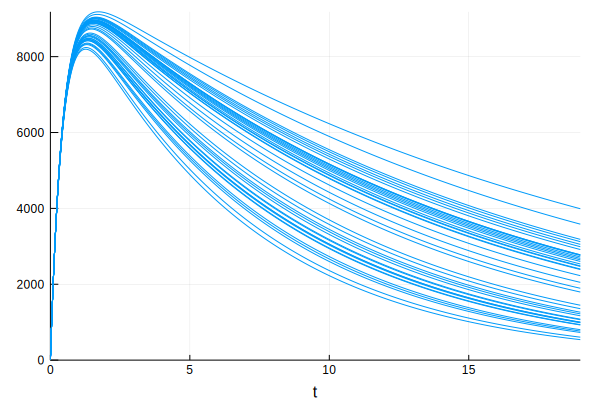

In [4]:
sols = pumas_solve(m_diffeq,data,x0,y0)
using Plots; gr()
# Plot controls are the same as DifferentialEquations.jl
plot(sols,vars=(0,2),lw=1,color=1)

## Many dosage regimes are available

- Bolus, extravascular (e.g. oral), and infusion doses
- Multiple compartment dosing
- Steady state dosing mixing various dosing strategies and overlaping
- Lag times, bioavailability, duration, etc.

Complex dosing scenarios are verified against the FORTRAN based industry standard software, NONMEM, with high accuracy (`<1e-12`)

## Example

`SS=2` (steady-state with reset) dosing with next dose overlapping into the steady-state interval

In [10]:
m_diffeq = @model begin
    @param   θ ∈ VectorDomain(3, lower=zeros(3), init=ones(3))
    @random  η ~ MvNormal(eye(2))
    @collate begin
        Ka = θ[1]; 
        CL = θ[2]*exp(η[1]); 
        V  = θ[3]*exp(η[2])
    end
    @dynamics begin
        dDepot   = -Ka*Depot; 
        dCentral =  Ka*Depot - (CL/V)*Central
    end
    @post cp = Central / V
end

subject = process_data(Pkg.dir("PuMaS", "examples/event_data","data15.csv"),
                       [], [:cp],  separator=',')[1]

x0 = @NT(θ = [1.5,1.0,30.0])
sol,_ = pumas_solve(m_diffeq, subject, x0, y0; abstol=1e-12, reltol=1e-12);

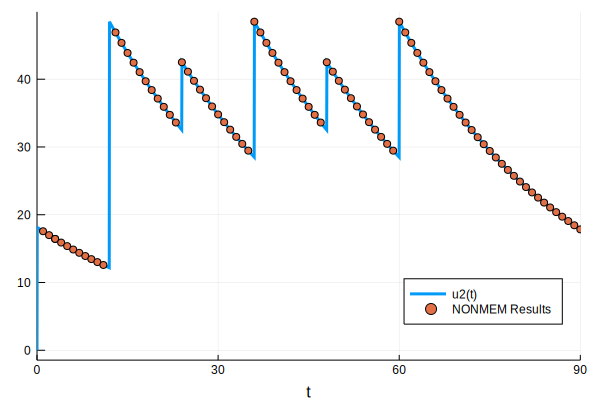

In [11]:
plot(sol,vars=(0,2),legend=:bottomright) # May want to label this as Julia Result
scatter!([obs.time for obs in subject.observations],30*[obs.val.cp for obs in subject.observations],label="NONMEM Results")

## There are many similar examples verifying the behavior

![pkpd_nonmem_tests](https://user-images.githubusercontent.com/1425562/43694592-10b40d44-9902-11e8-98e5-3d939a5e830b.png)

## Verified implementations of PBPK Models

![pbpk](https://user-images.githubusercontent.com/1425562/43694591-10ab2e86-9902-11e8-96a6-a7bd89549a43.png)

In [ ]:
using PMXSimulator, NamedTuples, Distributions, PDMats

pbpkmodel = @model begin
    @param begin
        GER = ConstDomain(0.066)
        ρ = ConstDomain(5e-6)
        r = ConstDomain(1)
        T = ConstDomain(3e-5)
        D = ConstDomain(1e-4)
        SST = ConstDomain(5.5)
        kilST = ConstDomain(0.5)
        kaST = ConstDomain(14040.00076)
        kaGU = ConstDomain(14040.000063)
        kt = ConstDomain(0.035)
        SGU1 = ConstDomain(5.5)
        SGU2 = ConstDomain(5.5)
        SGU3 = ConstDomain(5.5)
        SGU4 = ConstDomain(5.5)
        SGU5 = ConstDomain(5.5)
        SGU6 = ConstDomain(5.5)
        SGU7 = ConstDomain(5.5)
        kilGU1 = ConstDomain(0.5 )
        kilGU2 = ConstDomain(0.5)
        kilGU3 = ConstDomain(0.5)
        kilGU4 = ConstDomain(0.5)
        kilGU5 = ConstDomain(0.5)
        kilGU6 = ConstDomain(0.5)
        kilGU7 = ConstDomain(0.5)
        EHR = ConstDomain(0 )
        kbil = ConstDomain(0.0)
        VLI = ConstDomain(1690)
        Kp = ConstDomain(1.3)
        ktCO = ConstDomain(0.0007)
        SCO = ConstDomain(5.5)
        VCO = ConstDomain(700)
        kilCO = ConstDomain(0.0007)
        kaCO = ConstDomain(14040.0000542)
        CP = ConstDomain(0)
        QLU = ConstDomain(5233)
        VLU = ConstDomain(1172)
        VST1 = ConstDomain(50)
        VST2 = ConstDomain(154)
        VGU = ConstDomain(1650)
        VAR = ConstDomain(1698)
        AIR = ConstDomain(0.0)
        VVE = ConstDomain(3396)
        VIR = ConstDomain(0.0)
        QBR = ConstDomain(700)
        VBR = ConstDomain(1450)
        QLI = ConstDomain(1650)
        QKI = ConstDomain(1100)
        QHR = ConstDomain(150)
        VHR = ConstDomain(310)
        QMU = ConstDomain(750)
        VMU = ConstDomain(35000)
        QAD = ConstDomain(260)
        VAD = ConstDomain(10000)
        QSK = ConstDomain(300)
        VSK = ConstDomain(7800)
        QBO = ConstDomain(250)
        VBO = ConstDomain(4579)
        QTH = ConstDomain(80)
        VTH = ConstDomain(29)
        QST = ConstDomain(38)
        QGU = ConstDomain(1100)
        Ker = ConstDomain(0.0)
        QPA = ConstDomain(133)
        VPA = ConstDomain(77)
        QSP = ConstDomain(77)
        VSP = ConstDomain(192)
        CLint = ConstDomain(0)
        QHA = ConstDomain(302)
        VKI = ConstDomain(280)
        R = ConstDomain(1)
    end

    @random  η ~ MvNormal(eye(2))

    @dynamics begin
        #Absorption compartments
        #Stomach compartment
        dAUNDST = -GER * AUNDST - (((3*D)/(ρ*r*T)) * AUNDST* (SST - (ADIST/VST1)))
        dADIST = -GER * ADIST + (((3*D)/(ρ*r*T)) *AUNDST*(SST - (ADIST/VST1))) - kilST* ADIST -kaST *ADIST
        dADEGST = -GER * ADEGST + kilST * ADIST
        dAABSST = kaST * ADIST

        #GU1 small intestinal compartment
        dAUNDGU1 = GER * AUNDST - kt * AUNDGU1 - ((3*D)/(ρ*r*T)) * AUNDGU1 *(SGU1 - (ADISGU1/VGU))
        dADISGU1 = GER * ADIST - kt * ADISGU1 + ((3*D)/(ρ*r*T)) * AUNDGU1 *(SGU1 - (ADISGU1/VGU)) - kilGU1*ADISGU1 - kaGU*ADISGU1 + (EHR*kbil*CLI *VLI)/( Kp)
        dADEGGU1 = GER * ADEGST - kt * ADEGGU1 + kilGU1 * ADISGU1
        dAABSGU1 = kaGU * ADISGU1

        # Other small intestinal compartments (GU2–GU7)
        dAUNDGU2 = kt * AUNDGU1 - kt * AUNDGU2 -((3*D)/(ρ*r*T)) * AUNDGU2 *(SGU2 - (ADISGU2/VGU))
        dADISGU2 = kt * ADISGU1 - kt * ADISGU2 +((3*D)/(ρ*r*T)) * AUNDGU2 *(SGU2 - (ADISGU2/VGU)) - kilGU2*ADISGU2 - kaGU*ADISGU2
        dADEGGU2 = kt*ADEGGU1 - kt*ADEGGU2 + kilGU2 * ADISGU2
        dAABSGU2 = kaGU * ADISGU2

        dAUNDGU3 = kt * AUNDGU2 - kt * AUNDGU3 -((3*D)/(ρ*r*T)) * AUNDGU3 *(SGU3 - (ADISGU3/VGU))
        dADISGU3 = kt * ADISGU2 - kt * ADISGU3 +((3*D)/(ρ*r*T)) * AUNDGU3 *(SGU3 - (ADISGU3/VGU)) - kilGU3*ADISGU3 - kaGU*ADISGU3
        dADEGGU3 = kt*ADEGGU2 - kt*ADEGGU3 + kilGU3 * ADISGU3
        dAABSGU3 = kaGU * ADISGU3

        dAUNDGU4 = kt * AUNDGU3 - kt * AUNDGU4 -((3*D)/(ρ*r*T)) * AUNDGU4 *(SGU4 - (ADISGU4/VGU))
        dADISGU4 = kt * ADISGU3 - kt * ADISGU4 +((3*D)/(ρ*r*T)) * AUNDGU4 *(SGU4 - (ADISGU4/VGU)) - kilGU4*ADISGU4 - kaGU*ADISGU4
        dADEGGU4 = kt*ADEGGU3 - kt*ADEGGU4 + kilGU4 * ADISGU4
        dAABSGU4 = kaGU * ADISGU4

        dAUNDGU5 = kt * AUNDGU4 - kt * AUNDGU5 -((3*D)/(ρ*r*T)) * AUNDGU5 *(SGU5 - (ADISGU5/VGU))
        dADISGU5 = kt * ADISGU4 - kt * ADISGU5 +((3*D)/(ρ*r*T)) * AUNDGU5 *(SGU5 - (ADISGU5/VGU)) - kilGU5*ADISGU5 - kaGU*ADISGU5
        dADEGGU5 = kt*ADEGGU4 - kt*ADEGGU5 + kilGU5 * ADISGU5
        dAABSGU5 = kaGU * ADISGU5

        dAUNDGU6 = kt * AUNDGU5 - kt * AUNDGU6 -((3*D)/(ρ*r*T)) * AUNDGU6 *(SGU6 - (ADISGU6/VGU))
        dADISGU6 = kt * ADISGU5 - kt * ADISGU6 +((3*D)/(ρ*r*T)) * AUNDGU6 *(SGU6 - (ADISGU6/VGU)) - kilGU6*ADISGU6 - kaGU*ADISGU6
        dADEGGU6 = kt*ADEGGU5 - kt*ADEGGU6 + kilGU6 * ADISGU6
        dAABSGU6 = kaGU * ADISGU6

        dAUNDGU7 = kt * AUNDGU6 - kt * AUNDGU7 -((3*D)/(ρ*r*T)) * AUNDGU7 *(SGU7 - (ADISGU7/VGU))
        dADISGU7 = kt * ADISGU6 - kt * ADISGU7 +((3*D)/(ρ*r*T)) * AUNDGU7 *(SGU7 - (ADISGU7/VGU)) - kilGU7*ADISGU7 - kaGU*ADISGU7
        dADEGGU7 = kt*ADEGGU6 - kt*ADEGGU7 + kilGU7 * ADISGU7
        dAABSGU7 = kaGU * ADISGU7
        
        # Colon compartment
        dAUNDCO = kt * AUNDGU7 - ktCO * AUNDCO - ((3*D)/(ρ*r*T)) * AUNDCO * (SCO - (ADISCO/VCO))
        dADISCO = kt * ADISGU7 - kt * ADISCO + ((3*D)/(ρ*r*T)) * AUNDCO * (SCO - (ADISCO/VCO)) - kilCO*ADISCO -  kaCO*ADISCO + (CP*CLI*VLI*kbil)/( Kp)
        dADEGCO = kt * ADEGGU7 - ktCO * ADEGGU7 + kilCO * ADISCO
        dAABSCO = kaCO * ADISGU7

        #Total intestinal absorption (IA)
        dAIA = kaGU*ADISGU1 + kaGU*ADISGU2 + kaGU*ADISGU3 + kaGU*ADISGU4 + kaGU*ADISGU5 + kaGU*ADISGU6 + kaGU*ADISGU7
        
        #Somatic Compartments
        # Lungs
        dCLU = (QLU/VLU) *(CVE - (CLU*R)/(Kp))

        #Arterial blood (AR)
        dCAR = (1/VAR) * (QLU*(((CLU*R)/(Kp)) -CAR) + AIR)

        # Venous blood (VE)
        dCVE = (1/VVE) * (((QBR *CBR*R)/( Kp))  + ((QLI *CLI*R)/( Kp)) + ((QKI *CKI*R)/( Kp)) + ((QHR *CHR*R)/( Kp)) + ((QMU *CMU*R)/( Kp)) + ((QAD *CAD*R)/( Kp)) + ((QSK *CSK*R)/( Kp)) + ((QBO *CBO*R)/( Kp)) +((QTH *CTH*R)/( Kp)) - QLU * CVE + VIR)

        #Brain
        dCBR = (QBR/VBR)* (CAR - (CBR*R)/( Kp))
        #Heart
        dCHR = (QHR/VHR)* (CAR - (CHR*R)/( Kp))
        #Muscle
        dCMU = (QMU/VMU)* (CAR - (CMU*R)/( Kp))
        #Adipose
        dCAD = (QAD/VAD)* (CAR - (CAD*R)/( Kp))
        #Skin
        dCSK = (QSK/VSK)* (CAR - (CSK*R)/( Kp))
        #Bone
        dCBO = (QBO/VBO)* (CAR - (CBO*R)/( Kp))
        #Thymus
        dCTH = (QTH/VTH)* (CAR - (CTH*R)/( Kp))
        #Pancreas
        dCPA = (QPA/VPA)* (CAR - (CPA*R)/( Kp))
        #Spleen
        dCSP = (QSP/VSP)* (CAR - (CSP*R)/( Kp))

        #Stomach
        dCST = (1/VST2) * (QST*(CAR - ((CST*R)/(Kp))) + AABSST)
        #Gut
        dCGU = (1/VGU) * (QGU*(CAR - ((CGU*R)/(Kp))) + AIA)
        #Kidney
        dCKI = ((1/VKI) * QKI*(CAR - ((CKI*R)/(Kp)))) - ((CKI*Ker)/Kp)
        #Liver
        dCLI = (1/VLI)*(QHA*CAR + ((QGU *CGU*R)/( Kp)) + ((QPA *CPA*R)/( Kp)) + ((QSP *CSP*R)/( Kp)) + ((QST *CST*R)/( Kp)) - ((QLI *CLI*R)/( Kp)) - (CLI*CLint)/Kp )
    end
end

## So we can at least match previous software with open, verifiable, and continuously ran tests

![collaboration.png](https://user-images.githubusercontent.com/1425562/43694588-108cb7e4-9902-11e8-9e6b-ae0e2dedaea6.png)

### But what does partnering with the MIT Mathematics Department and the JuliaDiffEq development community add?

- Efficient toolkits for individualized and preicison dosing of patients
- Robust platforms to build systems biology and pharmacology models that aid in drug research
- Improved efficiency in modeling and simulation based decision making in drug development

DifferentialEquations.jl will support by -
- Providing a unique set of efficient methods integrating stiff ODEs with high efficiency.
- The integration techniques allow parallelism and GPU acceleration
- First class support for ODEs, SDEs, DAEs, DDEs, mixing discrete stochastic terms, etc.
- Continuous solutions for higher accuracy concentration maximum and area under the curve (AUC) calculations.
- Propogate parameter uncertainties through the integrators without resampling
- Global sensitivity analysis

## The GEAR/LSODE/CVODE Integrators are widely used in this field because of their efficiency

#### However, these methods are not efficient when there are events (doses!)

Test case: bouncing ball. Simplest ODE with events.

In [12]:
using OrdinaryDiffEq, Sundials, Plots
gr()


callback_f = function (du, u, p, t)
  du[1] = u[2]
  du[2] = -9.81
end

condtion= function (u,t,integrator) # Event when event_f(u,t,k) == 0
  u[1]
end

affect! = nothing
affect_neg! = function (integrator)
  integrator.u[2] = -integrator.u[2]
end

callback = ContinuousCallback(condtion,affect!,affect_neg!)

u0 = [50.0,0.0]
tspan = (0.0,15.0)
prob = ODEProblem(callback_f,u0,tspan);

## Using the right methods with high-order interpolations 

A standard high-performance BDF (GEAR) implementation (CVODE) takes 39 steps


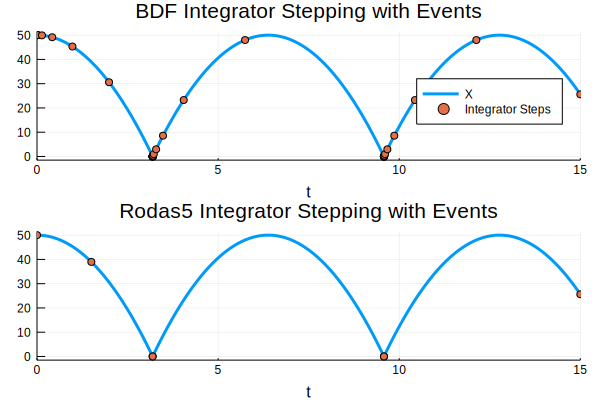

In [13]:
sol = solve(prob,CVODE_BDF(),callback=callback);
println("A standard high-performance BDF (GEAR) implementation (CVODE) takes $(length(sol)) steps")
p1 = plot(sol,vars=1,title = "BDF Integrator Stepping with Events",label="X",legend=:bottomright)
scatter!(p1,sol.t,sol[1,:],label = "Integrator Steps")
sol = solve(prob,Rodas5(),callback=callback, dt = 1.5);
println("Rodas5 takes $(length(sol)) steps")
p2 = plot(sol,vars=1,title = "Rodas5 Integrator Stepping with Events",legend=false)
scatter!(p2,sol.t,sol[1,:])
plot(p1,p2,layout = (2,1))

## PuMaS.jl can use any of DifferentialEquations.jl's solver methods

#### This means maximal efficiency, and as current research continues to progress the field, these methods will be automatically available in the simulator.

## In addition to newer and more refined methods specific to this problem domain, these Julia-based methods can utilize parallelism and GPU acceleration

Full example at http://www.stochasticlifestyle.com/solving-systems-stochastic-pdes-using-gpus-julia/

In [ ]:
# Define a bunch of constants for the PDE Discretization

# Now make the arrays on the GPU
using CLArrays
gA = CLArray(A); gB  = CLArray(B); gC = CLArray(C)
const gMx = CLArray(Mx)
const gMy = CLArray(My)
const gα₁ = CLArray(α₁)
gu0 = ArrayPartition((gA,gB,gC))
 
const gMyA = zeros(N,N)
const gAMx = zeros(N,N)
const gDA = zeros(N,N)

# Write standard vectorized code
function gf(du,u,p,t)
  A,B,C = u.x
  dA,dB,dC = du.x
  A_mul_B!(gMyA,gMy,A)
  A_mul_B!(gAMx,A,gMx)
  @. DA = D*(gMyA + AgMx)
  @. dA = DA + gα₁ - β₁*A - r₁*A*B + r₂*C
  @. dB = α₂ - β₂*B - r₁*A*B + r₂*C
  @. dC = α₃ - β₃*C + r₁*A*B - r₂*C
end

# Solve on the GPU
prob2 = ODEProblem(gf,gu0,(0.0,100.0))
sol = solve(prob2,BS3(),progress=true,dt=0.003,adaptive=false,save_everystep=false,save_start=false)

## Utilize the latest models: mix Discrete Markov Chains with Stochastic Differential Equations or Delay Differential Equations

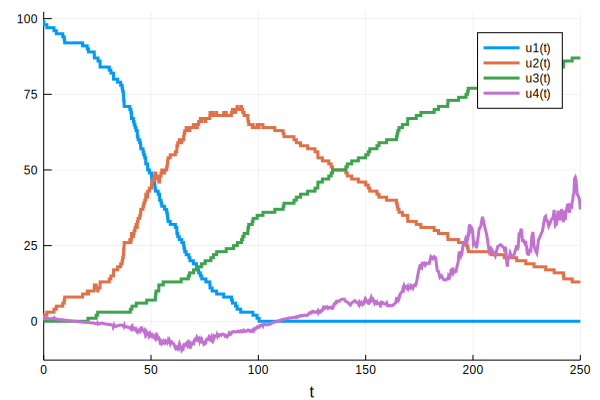

Rodas5 takes 7 steps


In [14]:
using DiffEqJump, StochasticDiffEq
rate1(u,p,t) = (0.1/100.0)*u[1]*u[2]
affect1!(integrator) = (integrator.u[1] -= 1; integrator.u[2] += 1)
jump = ConstantRateJump(rate1,affect1!)
rate2(u,p,t) = 0.01u[2]
affect2!(integrator) = (integrator.u[2] -= 1; integrator.u[3] += 1)
jump2 = ConstantRateJump(rate2,affect2!)

f2(du,u,p,t) = du[4] = u[2]*u[3]/10000 - u[1]*u[2]/10000
g2(du,u,p,t) = du[4] = 0.1u[4]

prob = SDEProblem(f2,g2,[99.0,1.0,0.0,1.0],(0.0,250.0))
jump_prob = JumpProblem(prob,Direct(),jump,jump2)
srand(100); sol = solve(jump_prob,SRIW1()) ; plot(sol)

## Continuous solutions give more accurate diagnostics

#### Concentration optima are typical indicators of dosing safety, but does traditional discrete output handling successfully identify optima?

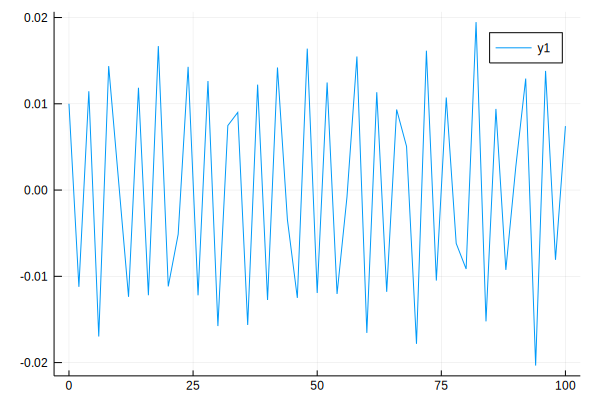

In [15]:
#Constants and setup
using OrdinaryDiffEq
initial = [0.01, 0.01, 0.01, 0.01]
tspan = (0.,100.)

#Define the problem
function double_pendulum_hamiltonian(udot,u,p,t)
    α  = u[1]
    lα = u[2]
    β  = u[3]
    lβ = u[4]
    udot .=
    [2(lα-(1+cos(β))lβ)/(3-cos(2β)),
    -2sin(α) - sin(α+β),
    2(-(1+cos(β))lα + (3+2cos(β))lβ)/(3-cos(2β)),
    -sin(α+β) - 2sin(β)*(((lα-lβ)lβ)/(3-cos(2β))) + 2sin(2β)*((lα^2 - 2(1+cos(β))lα*lβ + (3+2cos(β))lβ^2)/(3-cos(2β))^2)]
end

#Pass to solvers
poincare = ODEProblem(double_pendulum_hamiltonian, initial, tspan)
sol = solve(poincare, Tsit5());
plot(0:2:100,sol(0:2:100;idxs=3).u)

## Was 50 points enough to actually capture the behavior?

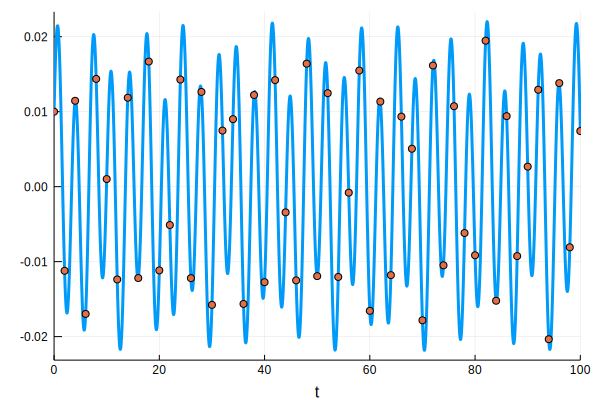

In [16]:
plot(sol, vars=(0,3), leg=false, plotdensity=10000)
scatter!(0:2:100,sol(0:2:100;idxs=3).u)

## With a continuous solution you can find global optima

In [17]:
using NLopt, ForwardDiff

count = 0 # keep track of # function evaluations

function g(t::Vector, grad::Vector)
  if length(grad) > 0 
    #use ForwardDiff for the gradients
    grad[1] = ForwardDiff.derivative((t)->sol(first(t),idxs=4),t)
  end 
  sol(first(t),idxs=4)
end
opt = Opt(:GN_ORIG_DIRECT_L, 1)
lower_bounds!(opt, [0.0])
upper_bounds!(opt, [40.0])
xtol_rel!(opt,1e-8)
min_objective!(opt, g)
(minf,minx,ret) = NLopt.optimize(opt,[20.0])
println(minf," ",minx," ",ret)
max_objective!(opt, g)
(maxf,maxx,ret) = NLopt.optimize(opt,[20.0])
println(maxf," ",maxx," ",ret)

-0.027931635264246215 

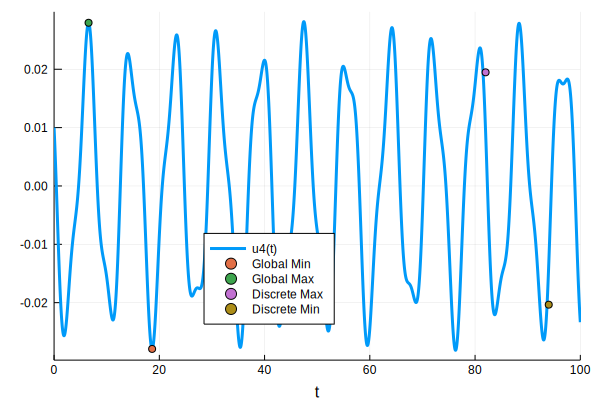

[18.6321] XTOL_REACHED
0.027968571933041936 [6.5537] XTOL_REACHED


In [18]:
disc_vals = sol(0:2:100;idxs=3)
dymax, ymax_idx = findmax(sol(0:2:100;idxs=3))
dymin, ymin_idx = findmin(sol(0:2:100;idxs=3))
plot(sol, vars=(0,4), plotdensity=10000,legend=:bottom)
scatter!([minx],[minf],label="Global Min")
scatter!([maxx],[maxf],label="Global Max")
scatter!([disc_vals.t[ymax_idx]],[dymax],label="Discrete Max")
scatter!([disc_vals.t[ymin_idx]],[dymin],label="Discrete Min")

## Propogate parameter uncertainties with the type system: no expensive resampling

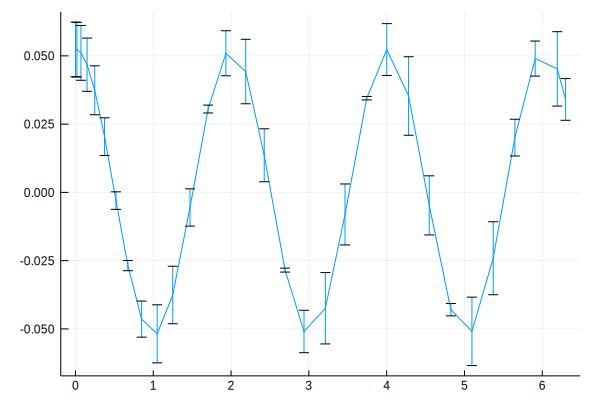

In [19]:
using Measurements
g_const = 9.79 ± 0.02; # Gravitational constants
L = 1.00 ± 0.01; # Length of the pendulum
u₀ = [0 ± 0, π / 60 ± 0.01] # Initial speed and initial angle
tspan = (0 ± 0, 6.3 ± 0)
function simplependulum(du,u,p,t)
    θ  = u[1]; dθ = u[2]; du[1] = dθ
    du[2] = -(g_const/L)*θ
end
prob = ODEProblem(simplependulum, u₀, tspan)
sol = solve(prob, Tsit5())
plot(Measurements.value.(sol.t), getindex.(sol.u, 2), legend=false)

## Integrated Global Sensitivity Analysis to identify sensitive parameters

![](https://user-images.githubusercontent.com/1814174/43667877-d64438b6-972e-11e8-8a6d-d9fca6504a2a.png)

## Global sensitivities of large PBPK/QSP models using parallelism and newer more efficient methods for solving stiff ODEs and propogating uncertainty, along with more accurate measurements for quantities of interest.

## Recap: where we are at

At this point we have:

- A simulator tested on PKPD, PBPK, and QSP models
- A high level DSL
- Automatic and symbolic differentiation to speed up solvers
- Uncertainty quantification without resampling
- Continuous output with high precision Cmax and AUC calculations
- High performance solvers specifically for handling problems in this domain
- Ability to handle delay, stochastic, and mixed discrete (Gillespie) differential equations
- Dosing regmine event handling verified to high precision against NONMEM
- Integration with sensitivity analysis, global optimization, and database tooling
- Implicit and explicit parallelization, including GPU acceleration
- Support for units and automatic conversions

## Quantitative Pharmaceutical Tools for All Project

- Julia Organization of Quantitative Pharmaceutical Tools (___QuantPharmTools___) - led by University of Maryland Baltimore
    * MIT and JuliaComputing as collaborators
    * A new joint UMB+MIT+JC Center for Predictive Healthcare Analytics to support software development
- Started as a few person side project, this month it is being upgraded to have full time and part time development staff
    * We are always looking for Julia developers knowledgable in differential equations, statistics, computational pharmacology/biology!
- Improving the front end DSL and documentation to release in January
    * Not all features can be used from the DSL yet!
- Nonlinear mixed effects model (NLME) estimation tools are in development
    * Includes Bayesian methods and interfaces with global optimization tools
- Libraries for PBPK/QSP models, bioequivalence, IVIVC analysis, and optimal experimental design are in development